# SCF optimization

The derivation of the [Kohn–Sham equation](kohn-sham-equation) follows closely the Hartree–Fock counterpart and the orbitals that minimize the DFT energy under the contraint of being orthogonal are eigenfuctions to the Kohn–Sham operator that closely resembles the [Fock operator](lagrangian) from Hartree–Fock theory. The Kohn–Sham operator takes the form

$$
\hat{f} = \hat{h} + \hat{v}_\mathrm{xc} + \sum_{j=1}^N \big( \hat{J}_j + c_{\text{x}} \hat{K}_j \big)
$$

where we note that the exchange term in the Fock operator has been at least partially replaced by the exchange–correlation potential

$$
v_\mathrm{xc}(\mathbf{r}) = \frac{\delta E_\mathrm{xc}}{\delta n(\mathbf{r})}
$$

For *pure* functionals, $c_{\text{x}} = 0$ whereas for *hybrid* functionals, we have $0 < c_{\text{x}} < 1$.

So an existing module for the [SCF optimization of a Hartree–Fock](scf-procedure) state is made capable to optimize a Kohn–Sham state by modifying the Fock operator accordingly. Let us do just that under the assumption that the exchange–correlation functional merely includes [Slater exchange](https://en.wikipedia.org/wiki/Local-density_approximation#Exchange_functional)

$$
\varepsilon_\mathrm{xc}(n(\mathbf{r})) =
-\frac{3}{4} \Big(\frac{3}{\pi}\Big)^{1/3} \big[n(\mathbf{r})\big]^{1/3}
$$

In the LDA, we have

$$
v_\mathrm{xc}(\mathbf{r}) =
\varepsilon_\mathrm{xc}(n(\mathbf{r})) + n(\mathbf{r})
\frac{\partial \varepsilon_\mathrm{xc}}{\partial n}
$$

and, in our particular case, we get

$$
v_\mathrm{xc}(\mathbf{r}) = \frac{4}{3} \varepsilon_\mathrm{xc}(n(\mathbf{r}))
$$

where

$$
n(\mathbf{r}) = 2 \times \sum_{i=1}^{N/2} \left|\phi_i(\mathbf{r})\right|^2
$$

In [1]:
import numpy as np
import scipy
import veloxchem as vlx

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 6.


## Setting up the system

In [2]:
mol_str = """3

O    0.000000000000        0.000000000000        0.000000000000
H    0.000000000000        0.740848095288        0.582094932012
H    0.000000000000       -0.740848095288        0.582094932012
"""

molecule = vlx.Molecule.read_xyz_string(mol_str)
basis = vlx.MolecularBasis.read(molecule, "cc-pVDZ", ostream=None)

In [3]:
molecule.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
norb = basis.get_dimensions_of_basis()
nocc = molecule.number_of_electrons() // 2
V_nuc = molecule.nuclear_repulsion_energy()

print("Number of orbitals:", norb)
print("Number of doubly occupied molecular orbitals:", nocc)
print(f"Nuclear repulsion energy (in a.u.): {V_nuc : 10.8f}")

Number of orbitals: 24
Number of doubly occupied molecular orbitals: 5
Nuclear repulsion energy (in a.u.):  9.34363816


## Reference calculation

Let us first perform an reference calculation using the restricted closed-shell SCF driver in VeloxChem.

In [5]:
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()

scf_drv.xcfun = "slater"

scf_drv.grid_level = 4
scf_drv.conv_thresh = 1.0e-6

scf_results = scf_drv.compute(molecule, basis)

In [6]:
print(f"Final DFT energy: {scf_drv.get_scf_energy() : 10.7f} Hartree")

Final DFT energy: -75.1874344 Hartree


In [7]:
# =============================================================
# integrals in AO basis
# =============================================================

# overlap matrix
S = vlx.compute_overlap_integrals(molecule, basis)

# one-electron Hamiltonian
T = vlx.compute_kinetic_energy_integrals(molecule, basis)

V = vlx.compute_nuclear_potential_integrals(molecule, basis)

h = T + V

# two-electron Hamiltonian
fock_drv = vlx.FockDriver()
g = fock_drv.compute_eri(molecule, basis)

# =============================================================
# DIIS convergence acceleration
# =============================================================


def c1diis(F_mats, e_vecs):
    n = len(e_vecs)

    # build DIIS matrix
    B = -np.ones((n + 1, n + 1))
    B[n, n] = 0

    for i in range(n):
        for j in range(n):
            B[i, j] = np.dot(e_vecs[i], e_vecs[j])

    b = np.zeros(n + 1)
    b[n] = -1
    w = np.matmul(np.linalg.inv(B), b)

    F_diis = np.zeros((norb, norb))
    for i in range(n):
        F_diis += w[i] * F_mats[i]

    return F_diis

## XC contribution to Fock matrix

The contrbutions from $\hat{v}_\mathrm{xc}$ to the Fock operator in the AO matrix representation will be obtained by means of numerical integration. 

$$
F^\mathrm{xc}_{\alpha\beta} = 
( \chi_\alpha | \hat{v}_\mathrm{xc} | \chi_\beta ) \approx
\sum_{g=1}^P
w_g \,
\chi_\alpha^\ast(\mathbf{r}_g)
v_\mathrm{xc}(\mathbf{r}_g)
\chi_\beta(\mathbf{r}_g)
$$

We start by defining a molecular grid with grid points and weights. The number of grid points, $P$, will depend on the chosen grid level accuracy. The default level in VeloxChem is equal to 4.

In [8]:
grid_drv = vlx.GridDriver()

grid_drv.set_level(4)  # default level in VeloxChem

molgrid = grid_drv.generate(molecule)

weights = molgrid.w_to_numpy()

In order to carry out the numerical integration, we need the values of the atomic orbitals, $\chi_\alpha(\mathbf{r}_g)$, on the grid points. 

In [9]:
xc_drv = vlx.XCIntegrator()

# generate AOs on the grid points
chi_g = xc_drv.compute_gto_values(molecule, basis, molgrid)

In [10]:
def LDA_exchange(D):
    # determine the total density on the grid points
    G = np.einsum("ab,bg->ag", D, chi_g)
    n = 2 * np.einsum("ag,ag->g", chi_g, G)

    e_xc = -0.75 * (3 / np.pi) ** (1 / 3) * n ** (1 / 3)
    E_xc = np.dot(weights, n * e_xc)

    v_xc = -((3 / np.pi) ** (1 / 3)) * n ** (1 / 3)

    F_xc = np.zeros((norb, norb))

    for alpha in range(norb):
        for beta in range(alpha, norb):
            F_xc[alpha, beta] = np.dot(weights, chi_g[alpha, :] * v_xc * chi_g[beta, :])
            F_xc[beta, alpha] = F_xc[alpha, beta]

    return F_xc, E_xc

## SCF procedure

Let us merely modify the Fock matrix in the existing module for the [SCF optimization of a Hartree–Fock](scf-procedure) state and instead converge the Kohn–Sham state. 

In [11]:
max_iter = 50
conv_thresh = 1e-6

e_vecs = []
F_mats = []

# initial guess from core Hamiltonian
epsilon, C = scipy.linalg.eigh(h, S)

print("iter       SCF energy   LDA exchange   Exact exchange   Error norm")

for iter in range(max_iter):
    D = np.einsum("ik,jk->ij", C[:, :nocc], C[:, :nocc])

    J = np.einsum("ijkl,kl->ij", g, D)
    F = h + 2 * J  # no exact exchange in the Fock matrix
    F_xc, E_xc = LDA_exchange(D)
    F += F_xc  # add LDA exchange
    F_mats.append(F)

    E = np.einsum("ij,ij->", 2 * h + 2 * J, D) + V_nuc
    E += E_xc

    # determine exact exchange for comparison
    K = np.einsum("ilkj,kl->ij", g, D)
    E_exact_exchange = np.einsum("ij,ij->", -K, D)

    # compute convergence metric
    e_mat = np.linalg.multi_dot([F, D, S]) - np.linalg.multi_dot([S, D, F])
    e_vecs.append(e_mat.reshape(-1))
    error = np.linalg.norm(e_vecs[-1])
    print(f"{iter:>2d} {E:18.8f} {E_xc:14.8f} {E_exact_exchange:16.8f} {error:12.2e}")

    if error < conv_thresh:
        print("SCF iterations converged!")
        break

    F = c1diis(F_mats, e_vecs)
    epsilon, C = scipy.linalg.eigh(F, S)

iter       SCF energy   LDA exchange   Exact exchange   Error norm
 0       -67.80508830   -10.89381306     -11.93847705     3.14e+00
 1       -66.26792219    -6.28078058      -7.13537283     4.19e+00
 2       -74.99359878    -7.76615742      -8.60690061     8.13e-01
 3       -75.12110246    -7.90554682      -8.73394901     5.65e-01
 4       -75.13715465    -7.92293008      -8.75103380     4.94e-01
 5       -75.16585462    -7.99147909      -8.82023741     3.22e-01
 6       -75.18739992    -8.11598421      -8.94844153     1.24e-02
 7       -75.18742612    -8.11619778      -8.94863105     6.35e-03
 8       -75.18743428    -8.11849075      -8.95101979     7.61e-04
 9       -75.18743440    -8.11879444      -8.95133716     1.63e-06
10       -75.18743440    -8.11879427      -8.95133701     7.68e-08
SCF iterations converged!


We note that the final SCF energy equals the one above as obtained in the reference calculation. It is also seen that the LDA exchange energy is some 0.83 Hartree higher than the corresponding exact Hartree–Fock exchange energy.

## Self-interaction error

In Hartee–Fock, the exchange energy equals

$$
E_{\mathrm{x}}^\mathrm{HF} = - \sum_{i=1}^{N/2} K_{ii}
; \qquad
K_{ii} = \sum_{j=1}^{N/2}
( \phi_i \phi_j | \phi_j \phi_i )
$$

The term in $K_{ii}$ with $j = i$ cancels the self-interaction in the classical Coulomb electron repulsion energy. In DFT, with an approximate form of the exchange–correlation energy functional, this cancelation is no longer guaranteed.

In our case, the DFT exchange energy equals

$$
E_{\mathrm{x}}^\mathrm{LDA} = 2
\sum_{i=1}^{N/2} ( \phi_i | \hat{\varepsilon}_\mathrm{xc} | \phi_i ) = 
\frac{3}{2} \sum_{i=1}^{N/2} ( \phi_i | \hat{v}_\mathrm{xc} | \phi_i ) =
\frac{3}{2} \sum_{i=1}^{N/2} F^\mathrm{xc}_{ii}
$$

where the factor of 2 stems from the double occupancy of orbitals.

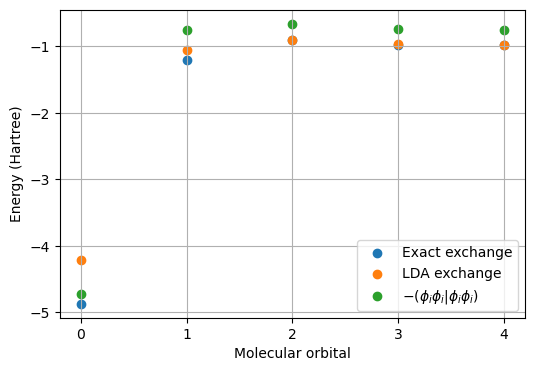

In [12]:
import matplotlib.pyplot as plt

F_xc_ii = []
K_ii = []
g_iiii = []

for i in range(nocc):
    F_xc_ii.append(np.einsum("a,b,ab->", C[:, i], C[:, i], F_xc))
    K_ii.append(np.einsum("a,b,ab->", C[:, i], C[:, i], K))
    g_iiii.append(np.einsum("a,b,c,d,abcd->", C[:, i], C[:, i], C[:, i], C[:, i], g))

LDA_x_ii = 1.5 * np.array(F_xc_ii)
HF_x_ii = -np.array(K_ii)
g_iiii = np.array(g_iiii)

fig = plt.figure(figsize=(6, 4))
ax = plt.axes(xticks=range(5))

ax.scatter(range(nocc), HF_x_ii, label="Exact exchange")
ax.scatter(range(nocc), LDA_x_ii, label="LDA exchange")
ax.scatter(range(nocc), -g_iiii, label=r"$-(\phi_i\phi_i | \phi_i\phi_i)$")

ax.legend(fontsize=10)
ax.grid(True)

plt.xlabel("Molecular orbital", fontsize=10)
plt.ylabel("Energy (Hartree)", fontsize=10)
plt.show()

First, we note that the self-interaction energy (SIE) in terms of the integral $(\phi_i\phi_i|\phi_i\phi_i)$ represents a dominant part of the exchange energy. The percentage contributions exceed 60% for all orbitals and it reaches 97% for the core 1s-orbital.

In [13]:
print("SIE percentage part of exchange energy")
for i in range(5):
    print(f"{i} {-g_iiii[i] / HF_x_ii[i] * 100 : 6.1f}%")

SIE percentage part of exchange energy
0   97.0%
1   62.8%
2   73.1%
3   76.5%
4   76.7%


Second, we note that the LDA exchange energy is closely equal to the exact Hartree–Fock exchange energy for the outer valence orbitals but substantially less so for the core and inner valence orbitals. For the core 1s-orbital, the two results differ by some 0.66 Hartree.

In [14]:
print("Comparison of LDA and HF exchange energies")
for i in range(5):
    print(
        f"{i} {LDA_x_ii[i] / HF_x_ii[i] * 100 : 6.1f}% {LDA_x_ii[i] - HF_x_ii[i] : 6.2f} a.u."
    )

Comparison of LDA and HF exchange energies
0   86.4%   0.66 a.u.
1   87.5%   0.15 a.u.
2   99.4%   0.01 a.u.
3   98.9%   0.01 a.u.
4   99.7%   0.00 a.u.
